In [1]:
import numpy as np
import os
import six.moves.urllib as urllib
import sys
import tarfile
import tensorflow as tf
import zipfile

from collections import defaultdict
from io import StringIO
from PIL import Image

from utils import label_map_util
from utils import visualization_utils as vis_util

In [2]:
MODELS = ['ssd_mobilenet_v1_coco', 'ssd_inception_v2_coco', 'rfcn_resnet101_coco', 'faster_rcnn_resnet101_coco', 'faster_rcnn_inception_resnet_v2_atrous_coco']

flags = tf.app.flags

flags.DEFINE_integer('model', 1, 'The model to use ' + str(MODELS))
flags.DEFINE_integer('classes', 100, 'The number of classes (default: 100)')
flags.DEFINE_string('date', '_11_06_2017', 'The date of model (default: _11_06_2017)')
flags.DEFINE_string('labels', 'mscoco_label_map.pbtxt', 'Label file (default: mscoco_label_map.pbtxt)')
flags.DEFINE_string('imgdir', 'images', 'Directory for input images (default: images)')
flags.DEFINE_string('outdir', 'output', 'Directory for output images (default: output)')
args = flags.FLAGS

# Model preparation  - What model to download.
MODEL_NAME = MODELS[args.model] + args.date
MODEL_PATH = os.path.join('model')
DOWNLOAD_BASE = 'http://download.tensorflow.org/models/object_detection/'
NUM_CLASSES = args.classes

# Path to frozen detection graph. This is the actual model that is used for the object detection.
PATH_TO_CKPT = os.path.join(MODEL_PATH, MODEL_NAME, 'frozen_inference_graph.pb')

# List of the strings that is used to add correct label for each box.
PATH_TO_LABELS = os.path.join('data', args.labels)
PATH_TO_IMAGES_DIR = args.imgdir
PATH_TO_OUTPUT_DIR = args.outdir

In [3]:
def get_model():
  tar_name = MODEL_NAME + '.tar.gz'
  tar_path = os.path.join(MODEL_PATH, tar_name)
  dir_path = os.path.join(MODEL_PATH, MODEL_NAME)
  print("Model Path: {}".format(dir_path))

  if not os.path.isfile(tar_path):
    print("Downloading Model: {}".format(tar_path))
    opener = urllib.request.URLopener()
    opener.retrieve(DOWNLOAD_BASE + tar_name, tar_path)

  if not os.path.isdir(dir_path):
    print("Extracting Model: {}".format(dir_path))
    tar_file = tarfile.open(tar_path)
    for file in tar_file.getmembers():
      file_name = os.path.basename(file.name)
      if 'frozen_inference_graph.pb' in file_name:
        tar_file.extract(file, MODEL_PATH)

In [4]:
# ## Helper code
def load_image_into_numpy_array(image):
  (im_width, im_height) = image.size
  return np.array(image.getdata()).reshape(
      (im_height, im_width, 3)).astype(np.uint8)


def get_image_paths(dir_path):
  files = [x for x in os.listdir(dir_path) if x.lower().endswith(('.png', '.jpg', '.jpeg'))]
  print("Total Image Files: {}".format(len(files)))
  return files


def load_detection_graph(ckpt_path): 
  # Load a (frozen) Tensorflow model into memory.
  detection_graph = tf.Graph()
  with detection_graph.as_default():
    od_graph_def = tf.GraphDef()
    get_model()

    with tf.gfile.GFile(ckpt_path, 'rb') as fid:
      serialized_graph = fid.read()
      od_graph_def.ParseFromString(serialized_graph)
      tf.import_graph_def(od_graph_def, name='')
  return detection_graph

In [8]:
# ## Loading label map
# Label maps map indices to category names, so that when our convolution network predicts `5`, we know that this corresponds to `airplane`.  Here we use internal utility functions, but anything that returns a dictionary mapping integers to appropriate string labels would be fine
label_map = label_map_util.load_labelmap(PATH_TO_LABELS)
categories = label_map_util.convert_label_map_to_categories(label_map, max_num_classes=NUM_CLASSES, use_display_name=True)
category_index = label_map_util.create_category_index(categories)

detection_graph = load_detection_graph(PATH_TO_CKPT)

with detection_graph.as_default():
  with tf.Session(graph=detection_graph) as sess:
    for file_name in get_image_paths(PATH_TO_IMAGES_DIR):

      image_path = os.path.join(PATH_TO_IMAGES_DIR, file_name)
      print("Processing Image: {}".format(image_path))
      image = Image.open(image_path)

      # the array based representation of the image will be used later in order to prepare the
      # result image with boxes and labels on it.
      image_np = load_image_into_numpy_array(image)
      # Expand dimensions since the model expects images to have shape: [1, None, None, 3]
      image_np_expanded = np.expand_dims(image_np, axis=0)
      image_tensor = detection_graph.get_tensor_by_name('image_tensor:0')
      # Each box represents a part of the image where a particular object was detected.
      boxes = detection_graph.get_tensor_by_name('detection_boxes:0')
      # Each score represent how level of confidence for each of the objects.
      # Score is shown on the result image, together with the class label.
      scores = detection_graph.get_tensor_by_name('detection_scores:0')
      classes = detection_graph.get_tensor_by_name('detection_classes:0')
      num_detections = detection_graph.get_tensor_by_name('num_detections:0')
      
      # Actual detection.
      (boxes, scores, classes, num_detections) = sess.run(
          [boxes, scores, classes, num_detections],
          feed_dict={image_tensor: image_np_expanded})
      
      # Visualization of the results of a detection.
      vis_util.visualize_boxes_and_labels_on_image_array(
          image_np,
          np.squeeze(boxes),
          np.squeeze(classes).astype(np.int32),
          np.squeeze(scores),
          category_index,
          use_normalized_coordinates=True,
          line_thickness=8)

      # Save the resulting image
      result_path = os.path.join(PATH_TO_OUTPUT_DIR, os.path.splitext(file_name)[0] + "_result.jpg")
      img = Image.fromarray(image_np, "RGB")
      img.save(result_path)
      print("Saved Image: {}".format(result_path))

Model Path: model/ssd_inception_v2_coco_11_06_2017
Total Image Files: 1
Processing Image: images/IMG_20170813_171615.jpg
Saved Image: output/IMG_20170813_171615_result.jpg


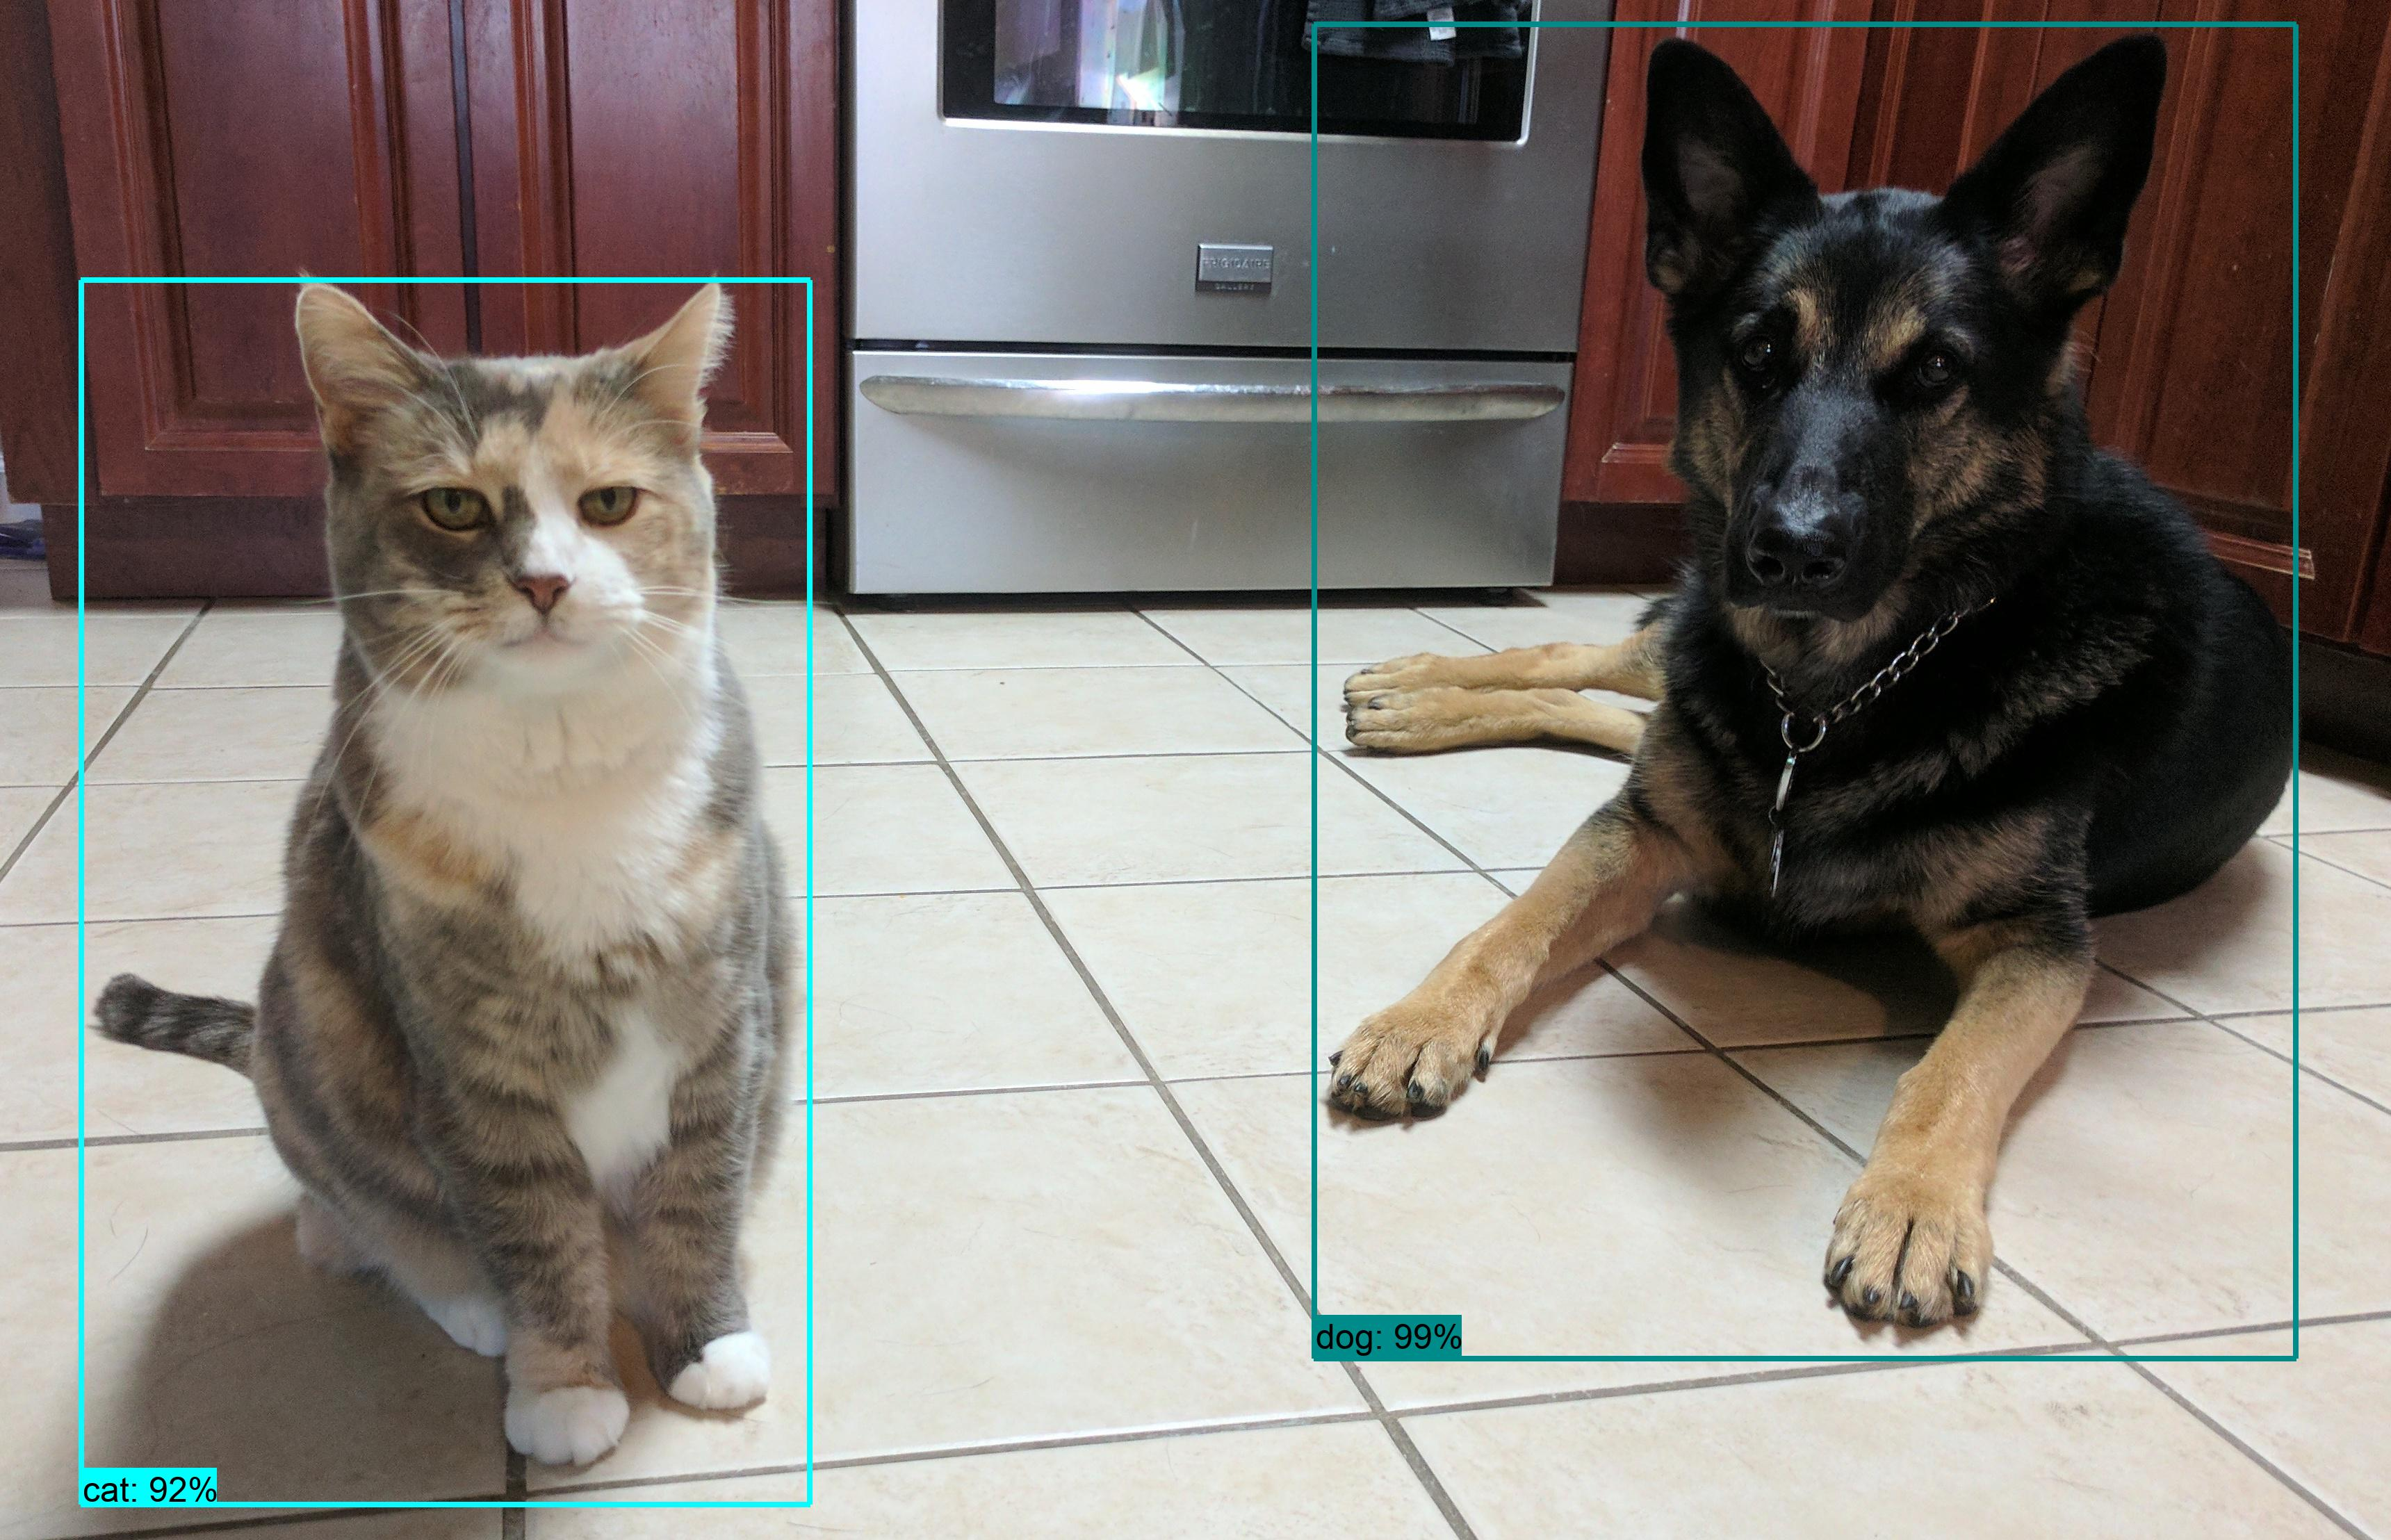

In [10]:
from IPython.display import Image
Image(filename='output/IMG_20170813_171615_result.jpg', width = 600, height = 300) 